# ERK2 단백질을 억제하는 분자를 예측하는 모델을 만든다
- 그래프 합성곱 모델 사용
- extracellular signal-regulated kinase (다수의 생화학적 신호에 관여하고 세포의 증식 분화 전사조절에 관여한다)
 - 비소세포성 폐암 non-small cell lung cancer과 흑색종(피부암)에 대해 임상시험중
 - DUD-E 데이터베이스에서 활성 및 비활성 분자 데이터 사용

In [ ]:
!pip install DeepChem

     |████████████████████████████████| 608 kB 3.9 MB/s 
     |████████████████████████████████| 22.5 MB 1.4 MB/s 


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")

- 분자 데이터는 SMILES 형식이다. 이를 데이터프레임에 불러온다
- AddMoleculeColumnToFrame()를 사용해 SMILES를 데이터프레임이 추가한다

In [ ]:
active_df = pd.read_csv("https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/mk01/actives_final.ism",
                        header=None,sep=" ")
active_rows,active_cols = active_df.shape
active_df.columns = ["SMILES","ID","ChEMBL_ID"]
active_df["label"] = ["Active"]*active_rows
PandasTools.AddMoleculeColumnToFrame(active_df,"SMILES","Mol")


## 데이터프레임에 계산된 특성을 추가하는 함수 정의
- 분자량 molecular weight, 
- 분배 계수 partition coefficeint(LogP) - 유성물질(옥탄올)에서 물로 분리되는 능력
- 전하 charge (양인지 음인지)

In [ ]:
def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
    df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]

In [ ]:
add_property_columns_to_df(active_df)

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,,565.099,5.49788,0
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,,466.541,4.35400,0
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,,527.915,4.96202,0
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,CHEMBL571484,Active,,491.935,4.36922,0
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,CHEMBL568937,Active,,487.991,5.12922,0

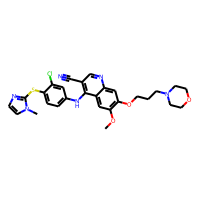
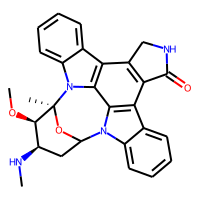
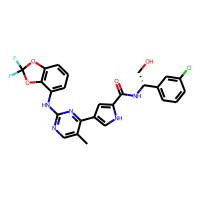
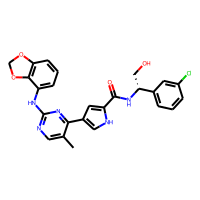
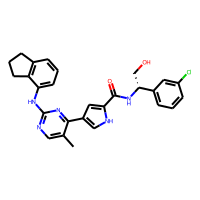

In [ ]:
active_df.head()

Now let's do the same thing with the decoy molecules

In [ ]:
decoy_df = pd.read_csv("https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/mk01/decoys_final.ism",
                       header=None,sep=" ")
decoy_df.columns = ["SMILES","ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df,"SMILES","Mol")
add_property_columns_to_df(decoy_df)

In [ ]:
tmp_df = active_df.append(decoy_df)

- violin plot

In [ ]:
%config InlineBackend.figure_format = 'retina'

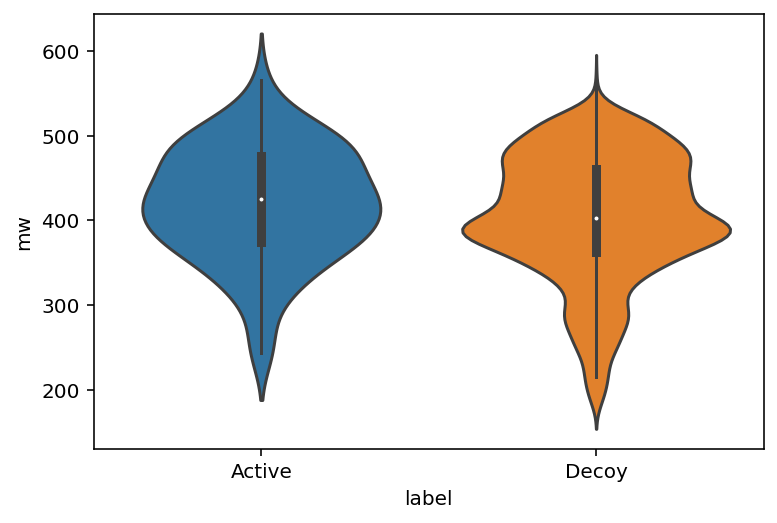

In [ ]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["mw"]);

- 위 그래프를 보면 분자량 분포는 비슷하다
- 400mw 이하의 분자들이 비활성 분자 데이터셋에 좀 더 많이 들어 있다

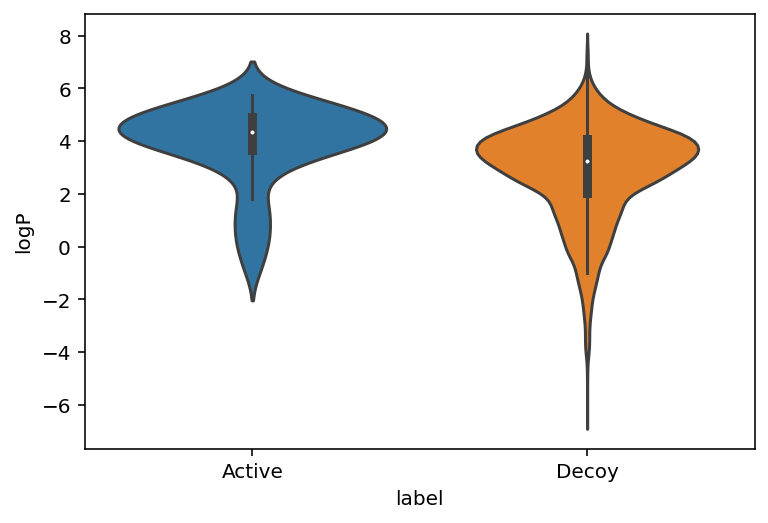

In [ ]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["logP"]);

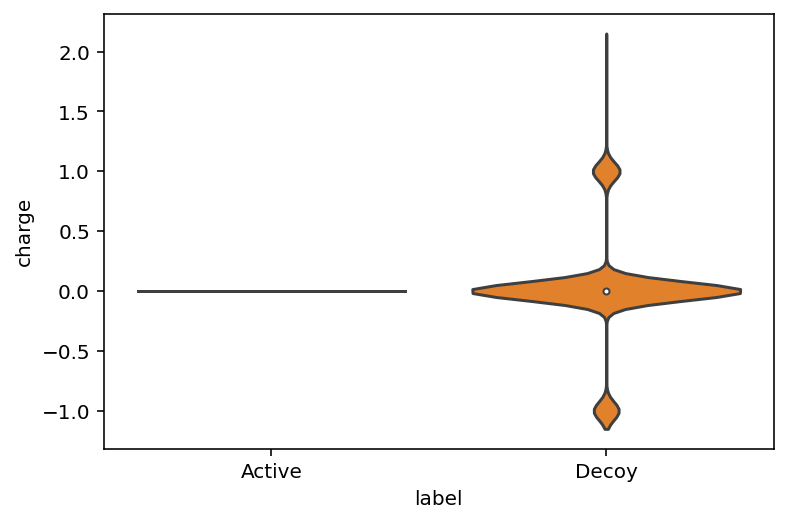

In [ ]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["charge"]);

- 활성 분자는 모두 중성이다
- 비활성 분자는 일부 +1과 -1이 있다

In [ ]:
charged = decoy_df[decoy_df["charge"] != 0]

In [ ]:
charged.shape[0]/decoy_df.shape[0]

0.16175824175824177

- 비활성 분자의 16%가 전하를 띠고 있다
- 전하 차이에 의해 머신러닝 모델이 바이어스가 생기게 되므로, 비활성 분자의 화학 구조를 수정하여 전하를 제거하겠다
- 아래는 이를 위한 함수 정의이다

In [ ]:
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None

def NeutraliseCharges(smiles, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    if replaced:
        return (Chem.MolToSmiles(mol,True), True)
    else:
        return (smiles, False)

In [ ]:
revised_decoy_df = decoy_df[["SMILES","ID","label"]].copy()

- 중성화된 SMILES만 사용하면 되므로 첫 번째 컬럼만 사용한다 (두번째 컬럼에는 전하여부를 나타내는 불리언 변수가 들어 있다)

In [ ]:
revised_decoy_df["SMILES"] = [NeutraliseCharges(x)[0] for x in revised_decoy_df["SMILES"]]


- 특성을 다시 계산한다
- 전하를 띤 샘플의 수가 감소했다

In [ ]:
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df,"SMILES","Mol")
add_property_columns_to_df(revised_decoy_df)

In [ ]:
new_tmp_df = active_df.append(revised_decoy_df)

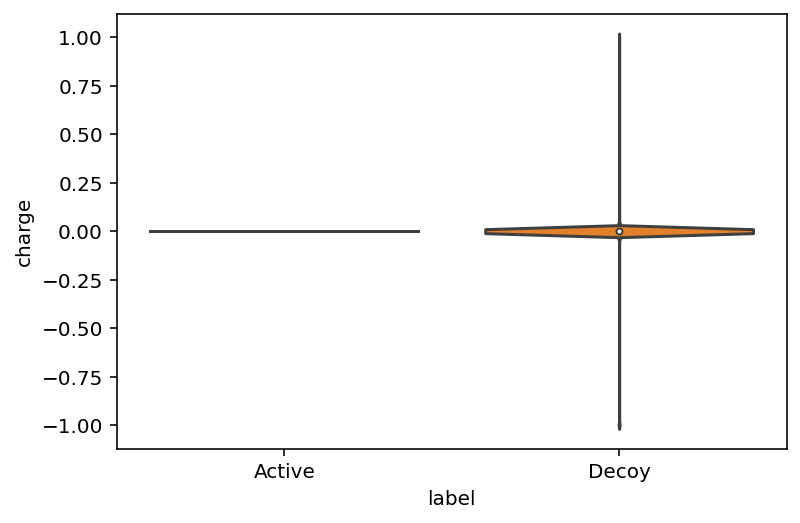

In [ ]:
sns.violinplot(x=new_tmp_df["label"],y=new_tmp_df["charge"])

In [ ]:
charged = revised_decoy_df[revised_decoy_df["charge"] != 0]
charged.shape[0]/revised_decoy_df.shape[0]

0.0026373626373626374

- 활성을 1로 비활성을 0으로 인코딩한다

In [ ]:
active_df["is_active"] = [1] * active_df.shape[0]
revised_decoy_df["is_active"] = [0] * revised_decoy_df.shape[0]
combined_df = active_df.append(revised_decoy_df)[["SMILES","ID","is_active"]]
combined_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [ ]:
# 파일로 저장해둔다
combined_df.to_csv("dude_erk1_mk01.csv")

## GCN 모델을 사용하여 이진 분류를 수행하겠다

In [ ]:
import deepchem as dc
from deepchem.models import GraphConvModel
import numpy as np
import sys
import pandas as pd
import seaborn as sns
from rdkit.Chem import PandasTools
from tqdm.auto import tqdm

## 그래프 합성곱 모델을 만드는 함수

In [ ]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size, 
             mode='classification', model_dir="./model_dir")
    return model

In [ ]:
dataset_file = "dude_erk1_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

## 랜덤하게 데이터를 나누는 함수 RandomSplitter()를 사용한다
- 참고로 화학 구조를 기반으로 데이터셋을 나누는 ScaffoleSplit()도 있고, 데이터를 군집화 한 후에 데이터셋을 분리하는 ButinaSplitter()도 있다

- 불균형 데이터에 대한 성능 평가시에는 매튜 상관계수 Matthews Correlarions Coefficients(MCC)를 사용한다
 - +1이면 완벽한 예측, 0이면 랜덤 예측, -1이면 완전히 반대되는 예측을 의미한다

In [ ]:
splitter = dc.splits.RandomSplitter()
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

In [ ]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 5
for i in tqdm(range(0,cv_folds)):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[0.33350130176592996, 0.8335382821675406, 0.8457022313739886, 0.5440658090366804, 0.8642479672720345]
[0.3508647326336185, 0.7534545402108427, 0.6518011356977635, 0.0, 0.771199299054495]


In [ ]:
np.array(training_score_list).mean(), np.array(validation_score_list).mean()

(0.6842111183232348, 0.5054639415193439)

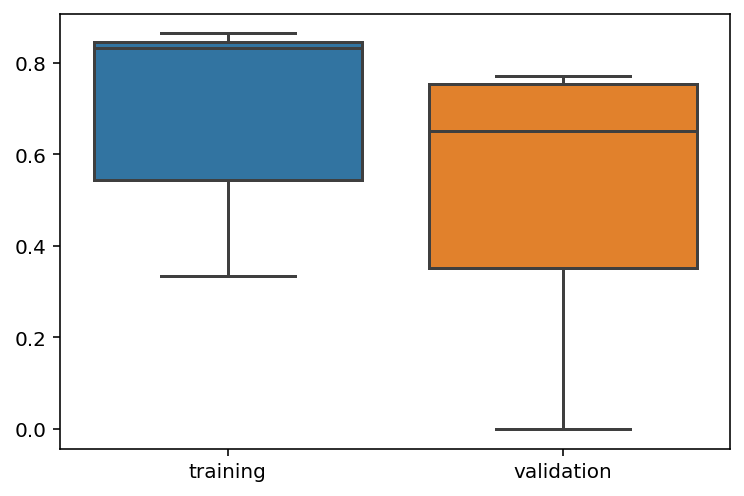

In [ ]:
sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);

## 검증 데이터에 대한 예측값을 시각화해보겠다

In [ ]:
pred = [x.flatten() for x in model.predict(valid_dataset)]

In [ ]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids
pred_df.head()

,neg,pos,active,SMILES
0,0.999299,0.000701,0,CCc1ccc(cc1)Nc2c(c3c(s2)c(c(c(n3)N)C#N)c4ccc(c...
1,0.995357,0.004643,0,C1CN[C@@H]([C@H]2C1=NCN2)C3=CC4=CC=N[C@@H]4C=C3
2,0.999118,0.000882,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...
3,0.999443,0.000557,0,Cc1ccc(cc1C)n2ccnc2S[C@H](C)C(=O)Nc3ccc(cc3)S(...
4,0.994158,0.005842,0,Cc1cc(Nc2ccc(NS(=O)(=O)c3ccc4c(c3)OCCO4)cc2)nc...


In [ ]:
pred_df.sort_values("pos",ascending=False).head(25)

,neg,pos,active,SMILES
275,0.051711,0.948289,1,c1ccc(cc1)CONC(=O)c2cc(c[nH]2)c3c(cn[nH]3)c4cc...
39,0.070323,0.929677,1,CCN(C)C(=O)c1cc(c[nH]1)c2c(cn[nH]2)c3cccc(c3)Cl
278,0.120704,0.879296,1,Cc1cc(ccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](...
193,0.221891,0.778109,1,CCc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](...
458,0.243141,0.756859,1,Cc1ccccc1Nc2ncc(c(n2)c3cc([nH]c3)C(=O)N[C@H](C...
102,0.332996,0.667004,1,c1cc(cc(c1)Cl)c2cn[nH]c2c3cc([nH]c3)C(=O)NC(CO...
147,0.591854,0.408146,1,CNC(=O)Nc1ccc(cn1)CNc2c(cnn2C)C(=O)Nc3ccc4c(c3...
85,0.799844,0.200156,0,CC1(O[C@@]2([C@@]([C@]([C@]([C@]([C@@]2(O1)C)(...
293,0.817406,0.182594,0,Cc1c(c2c(cc1N)N(C(=O)CCO2)C)C
118,0.882238,0.117762,1,CNC(=O)Nc1ccc(cn1)CNc2c(scn2)C(=O)Nc3ccc4c(c3)...


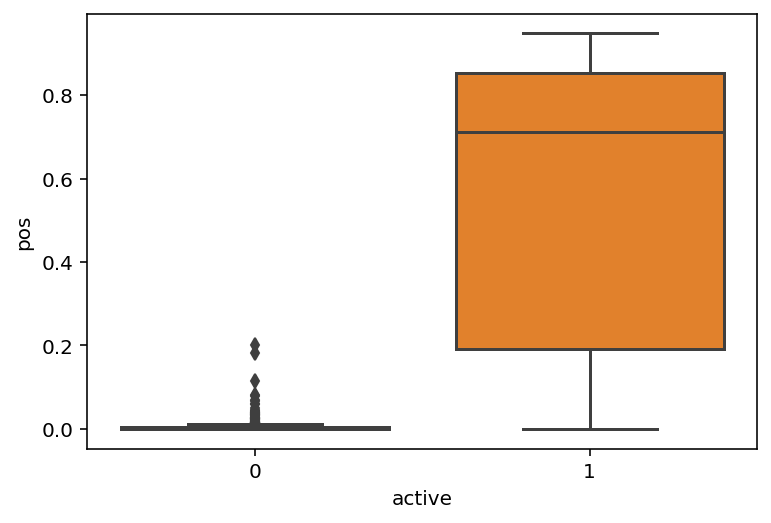

In [ ]:
sns.boxplot(x=pred_df.active,y=pred_df.pos)

- 위 그래프를 보면 활성 분자와 비활성 분자를 잘 구분하고 있는 것을 알 수 있다
- False Negative 샘플 찾기

In [ ]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

,neg,pos,active,SMILES,Mol
2,0.999118,0.000882,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
118,0.882238,0.117762,1,CNC(=O)Nc1ccc(cn1)CNc2c(scn2)C(=O)Nc3ccc4c(c3)...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
147,0.591854,0.408146,1,CNC(=O)Nc1ccc(cn1)CNc2c(cnn2C)C(=O)Nc3ccc4c(c3...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
454,0.999976,0.000024,1,c1c(c2c(ncnc2n1[C@H]3[C@@H]([C@@H]([C@H](O3)CO...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

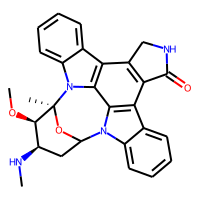
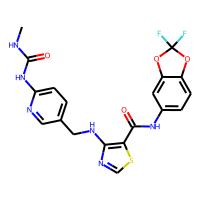
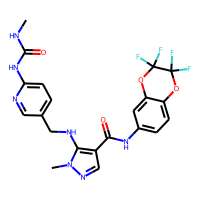
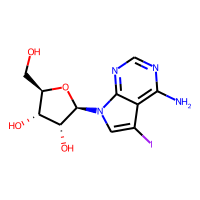

In [ ]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")
false_negative_df

- False Positive 샘플 찾기

In [ ]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")
false_positive_df

,neg,pos,active,SMILES,Mol


## 모든 데이터로 학습을 시킨다

In [ ]:
model.fit(dataset)

0.0007041013489166895

- 기존의 알고 있는 데이터셋으로 모델을 만들고 새로운 분자의 활성을 예측하게 된다.
- 위에서는 ERK2 단백질의 활성을 억제하는 분자를 예측하는 모델을 만들었다. 여기에 새로운 데이터셋을 사용하여 분자의 활성을 예측해보겠다
 - ZINC 데이터베이스의 일부를 사용하겠다
 - 생물학적 분석이 어려운 분자들을 제거하고 사용해야 한다 (ChEMBL 데이터베이스를 사용하겠다)
 - rd_filters.py 사용

In [ ]:
# !pwd

In [ ]:
# !git clone https://github.com/PatWalters/rd_filters

In [ ]:
# %cd rd_filters
# !pip install .

In [ ]:
# !pwd

In [ ]:
# %cd rd_filters

In [ ]:
# !ls

In [ ]:
# !python rd_filters.py -h

In [ ]:
# !pwd

In [ ]:
# !curl -o zinc_100k.smi https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/zinc_100k.smi

In [ ]:
# !ls

In [ ]:
# !python rd_filters.py filter --in zinc_100k.smi --prefix zinc

- Inpharmatica 규칙을 사용했으며 이는 생물학적 분석이 어려운 화합물을 제거하기 위해 사용한다
- SMILE 문자열 필터를 통과한 데이터는 zinc.smi 파일에 저장되며, 특정 구조를 형성한 화합물에 대한 정보는 zinc.csv에 저장된다
- 전체 분자중 68%가 통과하였다

## 다른 실행 방법

In [ ]:
% cd /content

/content


In [ ]:
!pwd

/content


In [ ]:
!pip install git+https://github.com/PatWalters/rd_filters.git


  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-bl7ud40j
  Running command git clone -q https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-bl7ud40j
  Created wheel for rd-filters: filename=rd_filters-0.1-py3-none-any.whl size=33802 sha256=7d0bade6326cf5ea0003df84a9c0e1455d95b09c80f7ea62af4d85b2b0838185
  Stored in directory: /tmp/pip-ephem-wheel-cache-ba9joak5/wheels/18/23/0c/f8d3c66d34f5ee86ae3992e1fdd45c94223ee21fcde6f01192
Successfully built rd-filters


In [ ]:
!rd_filters -h


Usage:
rd_filters filter --in INPUT_FILE --prefix PREFIX [--rules RULES_FILE_NAME] [--alerts ALERT_FILE_NAME][--np NUM_CORES]
rd_filters template --out TEMPLATE_FILE [--rules RULES_FILE_NAME]

Options:
--in INPUT_FILE input file name
--prefix PREFIX prefix for output file names
--rules RULES_FILE_NAME name of the rules JSON file
--alerts ALERTS_FILE_NAME name of the structural alerts file
--np NUM_CORES the number of cpu cores to use (default is all)
--out TEMPLATE_FILE parameter template file name


In [ ]:
!curl -o zinc_100k.smi https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/zinc_100k.smi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6159k  100 6159k    0     0  10.7M      0 --:--:-- --:--:-- --:--:-- 10.7M


In [ ]:
!rd_filters filter --in zinc_100k.smi --prefix zinc


using 2 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to zinc.smi
Wrote detailed data to zinc.csv
68410 of 100000 passed filters 68.4%
Elapsed time 122.39 seconds


## zinc.csv의 내용
- SMILES 문자역, 
- 분자의 이름(NAME), 
- 필터를 통과하지 못한 이유(FILTER), 
- 분자량(MW, 500보다 크면 통과하지 못한다), - 옥탄올/물 분배계수(LogP, 5보다 크면 통과하지 못한다)
- 수소결합의 공여체수 (HBD)

In [ ]:
df = pd.read_csv("zinc.csv")
df.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,Filter82_pyridinium > 0,311.342,-2.2813,2,9,105.52,6
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,Filter9_metal > 0,307.100,-1.0602,3,6,104.55,2
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,Filter82_pyridinium > 0,307.310,-1.7075,0,8,91.36,2
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4


- 어떤 필터에 의해서 가장 많이 걸러졌는지를 파악한다
 - collection의 Counter를 사용한다
 - 1,2디카르보닐 구조를 포함한 경우(아미노산 셀린 또는 시스테인과 공유결합을 형성하는 것으로 알려져 있다)
 - filter)collection.CSV 파일을 보면 1,2디카르보닐 구조를 의미하는 SMARTS 문자열'*C(=O)C(=O)*'를 확인할 수 있다.

In [ ]:
from collections import Counter
count_list = list(Counter(df.FILTER).items())
count_df = pd.DataFrame(count_list,columns=["Rule","Count"])
count_df.sort_values("Count",inplace=True,ascending=False)
count_df.head()

,Rule,Count
2,OK,69148
7,Filter41_12_dicarbonyl > 0,19330
0,Filter82_pyridinium > 0,7713
11,Filter93_acetyl_urea > 0,1541
12,Filter78_bicyclic_Imide > 0,825


In [ ]:
smiles_list = df[df.FILTER == "Filter41_12_dicarbonyl > 0"].SMILES[:10]


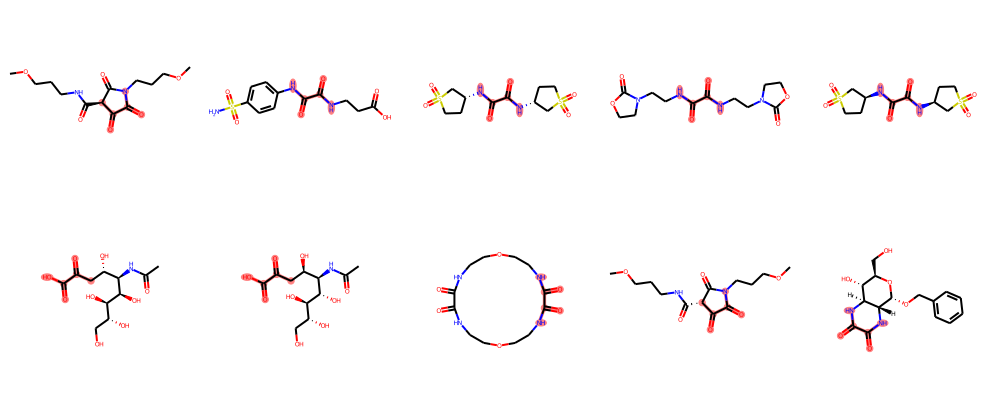

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
dicarbonyl = Chem.MolFromSmarts('*C(=O)C(=O)*')
match_list = [mol.GetSubstructMatch(dicarbonyl) for mol in mol_list]
Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list,molsPerRow=5)


# 모델 사용하기
- 모델을 불러오고, 피처화기를 만든후, 분자 데이터를 피처화 한다
- 예측값을 확인하고 가장 높은 점수를 얻은 화학구조를 확인한다
- 분자 데이터를 CSV로 저장한다

In [ ]:
import deepchem as dc
import pandas as pd
from rdkit.Chem import PandasTools, Draw
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
import seaborn as sns

- 피처함수를 사용한다
- SMILES 파일을 CSV로 변환해야 한다 (컬럼 추가)

In [ ]:
model = dc.models.GraphConvModel(1, batch_size=128, 
          mode='classification',model_dir="model_dir")
model.restore()

In [ ]:
df = pd.read_csv("zinc_100k.smi",sep=" ",header=None)
df.columns=["SMILES","Name"]
rows,cols = df.shape
df["Val"] = [0] * rows # 피처화를 위한 빈 자리
df.head()

,SMILES,Name,Val
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,0
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,0
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,0
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0


In [ ]:
infile_name = "zinc_filtered.csv"
df.to_csv(infile_name,index=False)

- CSV 파일을 읽어온다
- 모델을 사용하기 위해서 피처화된 데이터를 사용한다

In [ ]:
loader = dc.data.CSVLoader(tasks=['Val'], feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(infile_name, shard_size=8192)
pred = model.predict(dataset)


- 활성화와 비활성화를 구분하기 위해서 점수를 시각화 한다
- SMILES와 예측값이 있는 데이터프레임을 합친다
- 예측값이 높은 분자를 살펴본다

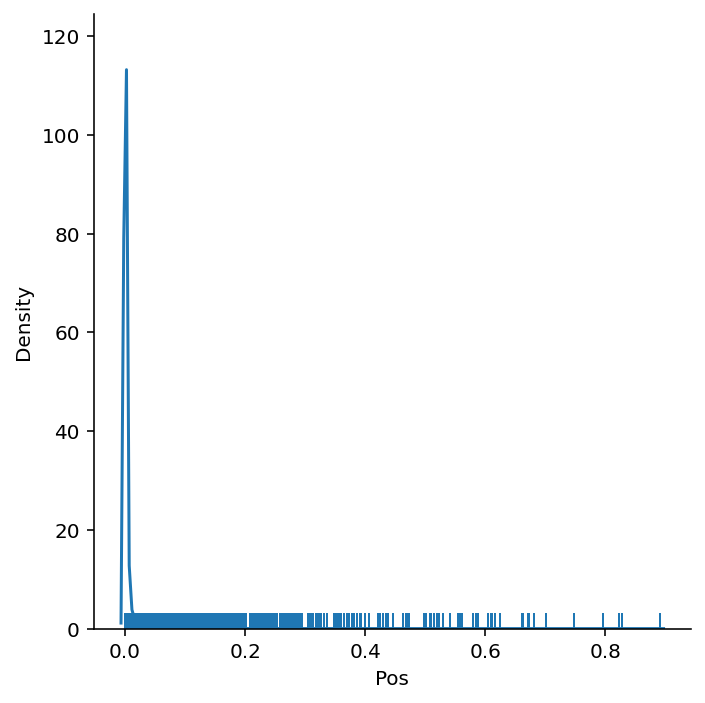

In [ ]:
pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])
sns.displot(x=pred_df.Pos,kind="kde",rug=True)


In [ ]:
combo_df = df.join(pred_df,how="outer")
combo_df.sort_values("Pos",inplace=True,ascending=False)


,SMILES,Name,Val,Neg,Pos,Mol
56476,Cn1nnc2cc(C(=O)NCC(=O)N3CCNCC3)cnc21,ZINC000562973487,0,0.109884,0.890116,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
69351,O=C(N[C@@H](CO)CN1CCOCC1)c1cnc2[nH]nnc2c1,ZINC000614410253,0,0.171701,0.828299,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
69350,O=C(N[C@H](CO)CN1CCOCC1)c1cnc2[nH]nnc2c1,ZINC000614410252,0,0.171701,0.828299,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
48099,Cn1ncc2c1nc(NCCNC(=O)c1cnccn1)nc2N,ZINC000436402607,0,0.177716,0.822284,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
2037,CNC(=O)c1cn([C@@H]2O[C@@H](CO)[C@@H](O)[C@H]2O...,ZINC000004824756,0,0.204145,0.795855,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

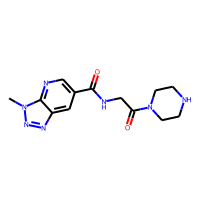
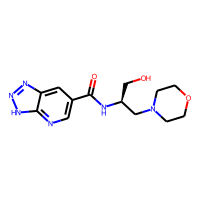
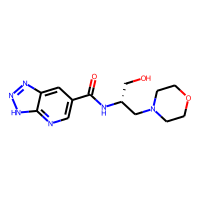
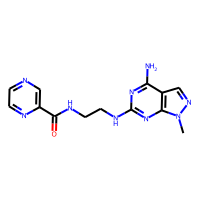
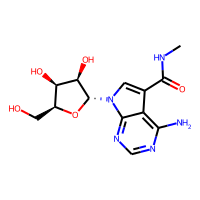

In [ ]:
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")
# combo_df.head()


,SMILES,Name,Val,Neg,Pos,Mol
56476,Cn1nnc2cc(C(=O)NCC(=O)N3CCNCC3)cnc21,ZINC000562973487,0,0.109884,0.890116,
69351,O=C(N[C@@H](CO)CN1CCOCC1)c1cnc2[nH]nnc2c1,ZINC000614410253,0,0.171701,0.828299,
69350,O=C(N[C@H](CO)CN1CCOCC1)c1cnc2[nH]nnc2c1,ZINC000614410252,0,0.171701,0.828299,
48099,Cn1ncc2c1nc(NCCNC(=O)c1cnccn1)nc2N,ZINC000436402607,0,0.177716,0.822284,
2037,CNC(=O)c1cn([C@@H]2O[C@@H](CO)[C@@H](O)[C@H]2O)c2ncnc(N)c12,ZINC000004824756,0,0.204145,0.795855,

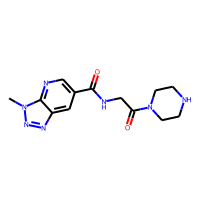
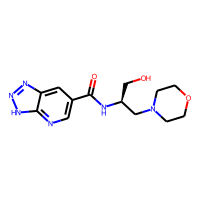
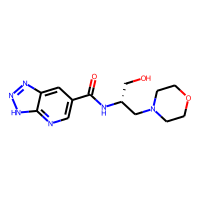
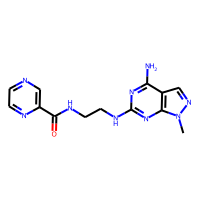
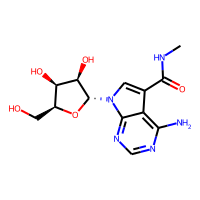

In [ ]:
from IPython.display import HTML
HTML(combo_df.head().to_html())

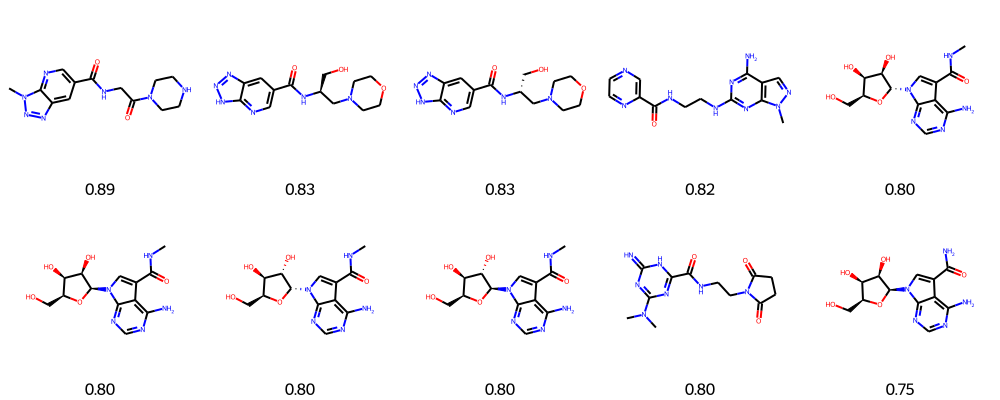

In [ ]:
Draw.MolsToGridImage(combo_df.Mol[:10],molsPerRow=5,legends=["%.2f" % x for x in combo_df.Pos[:10]])


- 예측값이 높는 분자들의 모양이 비슷한 것을 알 수 있다
- 중복되는 것을 피하기 위해서 군집화를 수행한다
 - 화학적 유사성을 사용하는 Butina 군집화를 사용하겠다

In [ ]:
def butina_cluster(mol_list,cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
56476,Cn1nnc2cc(C(=O)NCC(=O)N3CCNCC3)cnc21,ZINC000562973487,0,0.109884,0.890116,,62
69351,O=C(N[C@@H](CO)CN1CCOCC1)c1cnc2[nH]nnc2c1,ZINC000614410253,0,0.171701,0.828299,,18
69350,O=C(N[C@H](CO)CN1CCOCC1)c1cnc2[nH]nnc2c1,ZINC000614410252,0,0.171701,0.828299,,18
48099,Cn1ncc2c1nc(NCCNC(=O)c1cnccn1)nc2N,ZINC000436402607,0,0.177716,0.822284,,61
2037,CNC(=O)c1cn([C@@H]2O[C@@H](CO)[C@@H](O)[C@H]2O)c2ncnc(N)c12,ZINC000004824756,0,0.204145,0.795855,,1

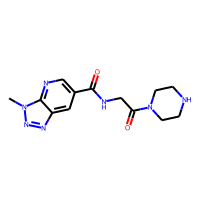
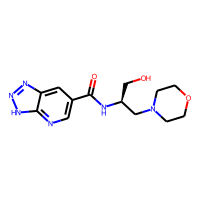
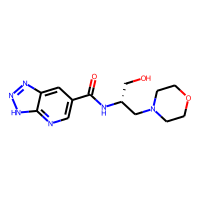
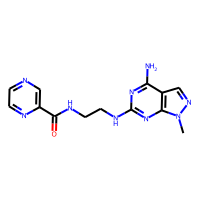
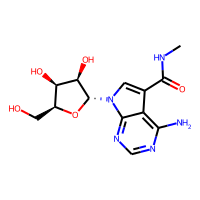

In [ ]:
best_100_df = combo_df.head(100).copy()
best_100_df["Cluster"] = butina_cluster(best_100_df.Mol)
# best_100_df.head()
HTML(best_100_df.head().to_html())


In [ ]:
len(best_100_df.Cluster.unique())
best_cluster_rep_df = best_100_df.drop_duplicates("Cluster")
best_cluster_rep_df.shape

(62, 7)

In [ ]:
best_cluster_rep_df.to_csv("best_cluster_represenatives.csv")
